## Predict Expected generation 
Use moving average, seasonal features, lag features, and cyclic encoding for hour of day. use other statistical model as needed.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [27]:
def run_prophet(df):
    '''
    Prophet automatically handles seasonality (daily, yearly, etc.) and trends.
    We do not need to include engineered features like lags, rolling averages, or cyclic encodings in the input DataFrame for Prophet.
    '''
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    prophet_data = df[['Date','Gen']].rename(columns={'Date':'ds','Gen':'y'})
    prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet.fit(prophet_data)
    forecast = prophet.predict(prophet_data)

    df['prophet_pred'] = forecast['yhat']  # seasonality + trend baseline
    df['residual'] = df['Gen'] - df['prophet_pred']
    return df


In [28]:
def run_xgboost(df):
    from xgboost import XGBRegressor
    
    res_features = ['Season_1','Season_2','Season_3','Season_4', 'POD_Night','POD_Morning','POD_Afternoon','POD_Evening','is_weekend','P/OP', 'is_vacation']
    X = df[res_features]
    y = df['residual']
    # y = df['Gen']

    # test-train split
    split_index = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:] 
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    reg = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.05,
        n_estimators=500
    )

    reg.fit(X_train, y_train)
    df.loc[X_test.index, 'xgb_pred'] = reg.predict(X_test)
    df['final_pred'] = df['prophet_pred'] + df['xgb_pred']

    # find accuracy for XGBoost residual model
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(df.loc[X_test.index, 'Gen'], df.loc[X_test.index, 'final_pred'])
    print(f"MAE: {mae}")
    
    return df, reg


## Predict for next 5 years
Expected generation (by month, peak and off-peak periods).

In [29]:
def run_prediction_pipeline(df):
    df_prophet = run_prophet(df)
    df_xgb, reg_xgb = run_xgboost(df_prophet)

    # Plot feature importance
    plt.figure(figsize=(8,6))
    plot_importance(reg_xgb, ax=plt.gca())
    plt.title("XGBoost Feature Importance")
    plt.show()

    # Create future dates (hourly for 5 years)
    # start from 1 january 2026
    future_dates = pd.date_range(
        start=pd.Timestamp('2026-01-01 00:00:00'),
        end=pd.Timestamp('2026-01-01 00:00:00') + pd.DateOffset(years=5),
        freq='h'
    )
    
    future_df = pd.DataFrame({'Date': future_dates})
    future_df['Month'] = future_df['Date'].dt.month
    future_df['Season'] = future_df['Month'].apply(lambda x: (x%12 + 3)//3)
    season_dummies = pd.get_dummies(future_df['Season'], prefix='Season')
    future_df = pd.concat([future_df, season_dummies], axis=1)
    future_df.drop(columns=['Month', 'Season'], inplace=True)  # drop intermediate columns

    # Add required features (example, adjust as needed)
    future_df['HE'] = future_df['Date'].dt.hour
    future_df['Period_of_Day'] = pd.cut(future_df['HE'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    pod_dummies = pd.get_dummies(future_df['Period_of_Day'], prefix='POD')
    future_df = pd.concat([future_df, pod_dummies], axis=1)
    future_df.drop(columns=['Period_of_Day'], inplace=True)

    # NERC holidays: New Year's Day, Memorial Day, Labor Day, Thanksgiving, and Christmas
    # add vacation indicator
    future_df['is_vacation'] = future_df['Date'].apply(
        lambda x: 1 if (x.month == 1 and x.day == 1) or
                         (x.month == 5 and x.day >= 25 and x.day <= 31 and x.weekday() == 0) or
                         (x.month == 9 and x.day >= 1 and x.day <= 7 and x.weekday() == 0) or
                         (x.month == 11 and x.month == 11 and x.day >= 22 and x.day <= 28 and x.weekday() == 3) or
                         (x.month == 12 and x.day == 25) else 0
    )
    
    # Peak hours 0 = off-peak, 1 = peak
    # Peak (P) hours = Mon-Fri, HE 7-22 excl NERC holidays
    future_df['P/OP'] = future_df.apply(
        lambda row: 1 if (row['Date'].weekday() < 5 and 7 <= row['Date'].hour <= 22 and row['is_vacation'] == 0) else 0,
        axis=1
    )

    future_df['day_of_week'] = future_df['Date'].dt.dayofweek
    future_df['is_weekend'] = future_df['day_of_week'].isin([5,6]).astype(int)
    

    # use Prophet to predict baseline generation
    prophet_data = future_df[['Date']].rename(columns={'Date':'ds'})
    forecast_future = Prophet(daily_seasonality=True, yearly_seasonality=True).fit(
        df[['Date','Gen']].rename(columns={'Date':'ds','Gen':'y'})
    ).predict(prophet_data)
    future_df['prophet_pred'] = forecast_future['yhat']

    # use XGBoost to predict residuals
    res_features = ['Season_1','Season_2','Season_3','Season_4', 'POD_Night','POD_Morning','POD_Afternoon','POD_Evening','is_weekend','P/OP', 'is_vacation']
    X_future = future_df[res_features]
    future_df['xgb_pred'] = reg_xgb.predict(X_future)
    future_df['final_pred'] = future_df['prophet_pred'] + future_df['xgb_pred']
    return future_df
    

04:23:43 - cmdstanpy - INFO - Chain [1] start processing
04:23:44 - cmdstanpy - INFO - Chain [1] done processing


MAE: 16.50502919432458


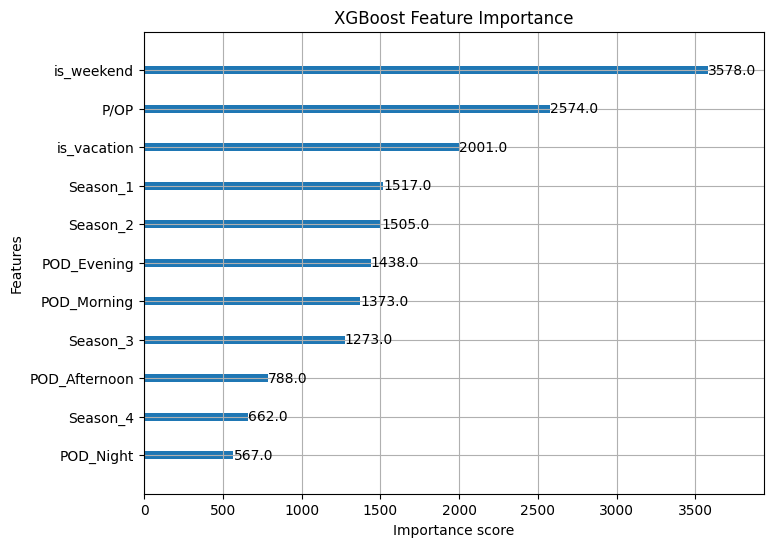

04:23:48 - cmdstanpy - INFO - Chain [1] start processing
04:23:49 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
data_dir = "../data"
caiso_historical_df = pd.read_csv(data_dir + "/CAISO-Historical-Data.csv")
prediction = run_prediction_pipeline(caiso_historical_df)

In [31]:
prediction.to_csv(data_dir + "/CAISO-Future-Predictions.csv", index=False)

In [32]:
# check how the percentage have negative values
negative_percentage = (prediction[prediction['final_pred'] < 0].shape[0] / prediction.shape[0]) * 100
negative_percentage

16.415288077581287

In [33]:
prediction

,Date,Season_1,Season_2,Season_3,Season_4,HE,POD_Night,POD_Morning,POD_Afternoon,POD_Evening,is_vacation,P/OP,day_of_week,is_weekend,prophet_pred,xgb_pred,final_pred
0,2026-01-01 00:00:00,True,False,False,False,0,True,False,False,False,1,0,3,0,32.927346,-22.482349,10.444996
1,2026-01-01 01:00:00,True,False,False,False,1,True,False,False,False,1,0,3,0,26.166864,-22.482349,3.684514
2,2026-01-01 02:00:00,True,False,False,False,2,True,False,False,False,1,0,3,0,10.867629,-22.482349,-11.614720
3,2026-01-01 03:00:00,True,False,False,False,3,True,False,False,False,1,0,3,0,-2.272245,-22.482349,-24.754594
4,2026-01-01 04:00:00,True,False,False,False,4,True,False,False,False,1,0,3,0,-5.794673,-22.482349,-28.277023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43820,2030-12-31 20:00:00,True,False,False,False,20,False,False,False,True,0,1,1,0,38.448797,-24.953777,13.495020
43821,2030-12-31 21:00:00,True,False,False,False,21,False,False,False,True,0,1,1,0,41.987121,-24.953777,17.033344
43822,2030-12-31 22:00:00,True,False,False,False,22,False,False,False,True,0,1,1,0,55.150333,-24.953777,30.196556
43823,2030-12-31 23:00:00,True,False,False,False,23,False,False,False,True,0,0,1,0,70.480117,-25.354149,45.125968
